# Task 1: Sentence decoding

## Importing different Language Models

In [1]:
import sys
import os
import numpy as np

def read_vectors_from_file(filename):
    d = {}
    with open(filename, 'rt') as infile:
        for line in infile:
            word, *rest = line.split()
            d[word] = np.array(list(map(float, rest)))
    return d


glove = read_vectors_from_file("data/glove.6B.300d.txt")

In [3]:
# import a word2vec model from gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
w2v = gensim.downloader.load('fasttext-wiki-news-subwords-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Load the data

In [33]:
# Download and extract the data and learn_decoder.py
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!wget --header="Host: drive.usercontent.google.com" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-US,en;q=0.9,he;q=0.8" --header="Cookie: HSID=AHJfxja1o67aaDDKP; SSID=AcFaYUEeiC88MwrF9; APISID=-FXvHmBvJ828Jrpq/AaIp_RI6gKwBAA-zy; SAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-1PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-3PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; S=billing-ui-v3=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:billing-ui-v3-efe=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:maestro=dsv3G-owxPD6uTATLH0lBQZNadhFo6ZKJiuB9usoQVU; __Secure-BUCKET=CPgG; SID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx_uObP_F4bCqI8I561ccGMwACgYKAWESARQSFQHGX2Mi5DnhBiJ2gjjbMSP0XJbU5BoVAUF8yKrlBjWMdNOfGnmA7TZzmbWD0076; __Secure-1PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx2BFINS8lXhFUyAFwuvl8CQACgYKAW4SARQSFQHGX2MiWd6bHkI0JN89-1dFZUbS2hoVAUF8yKpc-H3AD8N6tj-dmFG21SeE0076; __Secure-3PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyxJl_TGsCsjeiVN72q3lSCWQACgYKASASARQSFQHGX2MiULluXa7aABDwxgCWjB6IyhoVAUF8yKoy_HHYLCqIFMwNjx-GwYWe0076; __Secure-ENID=20.SE=jyM_w2hA8DW6FvPOh9wudde93a0A9P41Epzo098LV_LyU79-VVcJ9K-vNLrhCLuVzi69CyV4RxlSls8AAT9J8odwIXi_ISVn8Z1U1DH52BC3YiwOwO9LKUsBesCbGx2D6u1XwZ5GIP_PZMo1tkLLJq2VCtcxRP9OtC_QgHNbAD4eyc1TTu1C8XbZLFTOIgb0k9IfM2bMBXeha6t3sJysARZWpDIzs3I8wWZ5JtABB253grtjQyCnxyy9MUgTcYAVaoEGwgVHV4V4lSY6gydFkO2gYxl7JqYloqCq74HahGK54TBlsGZIOTM_KvFAsIidcrPaVOBpH6IGQTPChxy3Tr-GLK7VpBiQ8JW7V0xC8XTN1crEaaZnGFQ6MrjDv8f3hCY0Kg; AEC=AQTF6HwEtUB747fVHMzvOWJV9pmRoGs8Ix8FJ1HTrxbE9NY1dtyro2AvNQ; NID=515=Wdt0NWZqVSh3TtdIfjXCGTCCkj7jaJjt-lkOL3hLD_hPSSMyGxKkVthECwGGFbbxmvfM2iKZ1SkPGDVgLwjghAOrV9Ya7iEJJ0eSXZSfszc0WxRXm3Jy6LxqPEZLmY8v3AIkMX-o8KE5ZRXGEzgv_s9pfgS8bmeiIGT13Iiyw9tPzRZDChGijNbZ0Mp1oF-4YKikOZCyo8Km9wXOgLAC9dbeIqAlTdER97cQ7B5GajyRLH_bFrg0lCVN4tyZEycjihHOu6Eq_V88rswgV7uvzemJ_yk4WbbIWJVm9NCO4tWdDQG8NY3EY57xAJbmIhu260jDftYwzjCnpqJ8C1iCm-FjboF6xJwKJEtLkCXagIcSWxfPGqRWIn5KY72ogAMZTlUZ5RE5F8bH4sFgkt5pW_AalY5mxYPOfZgF-9hcJYsF71rMOic6mqSfvR8iNo-k6_SZ-4o5WkYxbwdLgiaIOiCJHkhIGBoXsm5hh5BHDqlk5ERGnFn5zpqOguNLJFjXT3nhaP1g_a2fFvd0bmZw2A9Y6tBNAC7CbDOmSHSmYmLag0qVcqu286CZh5svuhdM-QPcSCt5u0kPgfWN3KBha0G9L9qCiDIwntvnlVNoUYLBM4je1bhGjO9M2tdH_vteLo4vjm9Cq-4I2A; __Secure-1PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; __Secure-3PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; SIDCC=AKEyXzW7IJ8miV8hX_pqzqqPW7--eMWuWfausspLBoDPlfZDCRZDED56ohpancLYOBPizfUzi1aM; __Secure-1PSIDCC=AKEyXzVGnmSuG07J22njRVFPQ_sk88MgnqtYxJd-M0_9Pz3jdh4GpGPhPOqCMrayTU9SJTW3n54; __Secure-3PSIDCC=AKEyXzVScJYbKdtIImPYKpTRkExsc5UhC5n9Rkk8wNFlMZNW3_xkvWlimAXWaZ4T7kTcJy5AE4I" --header="Connection: keep-alive" "https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172" -c -O 'files.zip'
!unzip files.zip
!rm files.zip

--2025-05-09 14:51:32--  https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.75.65
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.75.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97708666 (93M) [application/octet-stream]
Saving to: ‘files.zip’

files.zip           100%[===================>]  93.18M  14.0MB/s    in 9.1s    

2025-05-09 14:51:42 (10.3 MB/s) - ‘files.zip’ saved [97708666/97708666]

Archive:  files.zip
  inflating: stimuli_180concepts.txt  
  inflating: learn_decoder.py        
  inflating: vectors_180concepts.GV42B300.txt  
  inflating: imaging_data.csv        


In [4]:
#Let's load the functions from learn_decoder.py
from learn_decoder import *

#and the data
data = read_matrix("imaging_data.csv", sep=",")
glove_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))  #The names of the 180 concepts
# creating a matrix of the word2vec vectors and custom glove vectors
word2vec_vectors = np.zeros((len(concepts), 300), dtype=np.float32)
custom_glove_vectors = np.zeros((len(concepts), 300), dtype=np.float32)
for i, concept in enumerate(concepts):
    if concept in w2v:
        word2vec_vectors[i] = w2v[concept]
    else:
        print(f"Warning: '{concept}' not found in Word2Vec model. Defaulting to a zero vector.")
        word2vec_vectors[i] = np.zeros(300, dtype=np.float32)
    if concept in glove:
        custom_glove_vectors[i] = glove[concept]
    else:
        print(f"Warning: '{concept}' not found in custom GloVe model. Defaulting to a zero vector.")
        custom_glove_vectors[i] = np.zeros(300, dtype=np.float32)

In [5]:
print(data.shape)
print(glove_vectors.shape)
print(word2vec_vectors.shape)
print(custom_glove_vectors.shape)
print(concepts.shape)

(180, 170712)
(180, 300)
(180, 300)
(180, 300)
(180,)


In [6]:
# splitting the data into 18 folds
np.random.seed(3)

n_folds = 18
n_samples = data.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)
folds = np.array_split(indices, n_folds)
print(folds)

[array([ 25,   3,  82, 177, 156, 132,   6,  86,  70,  58]), array([ 83,  34,  38, 101,   4, 115,  23,  77,  87,  15]), array([168,  71, 161,  47, 120,  98, 171,  42,  40, 143]), array([122,  89,  51,  73,  72, 102,  64, 136, 178,  46]), array([ 17,  41,  31, 153,   5, 164,  92, 173, 174,  12]), array([ 14,  24, 100,  67,   8, 112,  53,  27,  78, 108]), array([144,  43, 128,  57, 162,  22, 151, 145, 109,  63]), array([121, 133, 154,  45,  35,  65,  50, 118, 167,  19]), array([163, 105,  68,  76, 125,  10,  84,  11, 130,  88]), array([159, 111,   9, 103, 158,  29,  39,  56, 175, 165]), array([139,  74,  59, 134,  44, 155, 157,  36, 141, 160]), array([ 52, 135,  61,  48,  30, 146,  13,  95,  96,  55]), array([ 75, 137, 114, 126,  32,  80,  16,  91,  99, 124]), array([140, 117,  85,   1, 113, 170, 116,  18, 176,  54]), array([172,  28, 127,  49,  94,  20,  37,  79, 123,  33]), array([  7,  62, 179,  97, 110, 104,  69,  90, 129,  60]), array([  2,  66, 150,  81,  26, 142,  93, 148, 166, 119

### What are the Accuracy scores?

Define a function that computes rank-based accuracy score, then, iterate over the 18 folds. For each fold,  train the decoder **using the `learn_decoder` function** (the function is already imported from `learn_decoder.py`) on the fold train data, obtain the predicions on the fold test data, and store both the accuracy score of each concept (use the labels from `concepts`) as well as the average score of the 10 concepts.

In [7]:
def test_accuracy(folds, embedding_vectors):
    concept_accuracies = {}
    fold_accuracies = []

    for test_id, test_fold in enumerate(folds):
        train_folds = [fold for i, fold in enumerate(folds) if i != test_id]
        train_indices = np.concatenate(train_folds)
        test_indices = test_fold

        train_data = data[train_indices]
        test_data = data[test_indices]

        train_vectors = embedding_vectors[train_indices]
        test_vectors = embedding_vectors[test_indices]

        # Train the decoder
        decoder = learn_decoder(train_data, train_vectors)

        # Get predictions
        predictions = test_data @ decoder

        # Compute accuracy scores
        accuracy_scores = []
        # for each prediction, sorting all vectors by cosine similarity to the prediction
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = test_vectors[i]
            # Compute cosine similarity with all vectors
            similarities = np.dot(embedding_vectors, pred) / (np.linalg.norm(embedding_vectors, axis=1) * np.linalg.norm(pred))
            # Sort by similarity
            sorted_indices = np.argsort(similarities)[::-1]
            # Get the index of the target vector
            target_index = np.where(np.all(embedding_vectors[sorted_indices] == target, axis=1))[0][0] + 1
            accuracy_scores.append(target_index)
            # Store the accuracy score for the concept
            concept_name = concepts[test_indices][i]
            concept_accuracies[concept_name] = target_index
        # Compute the average accuracy score
        avg_accuracy = np.mean(accuracy_scores)
        fold_accuracies.append(avg_accuracy)
    
    return concept_accuracies, fold_accuracies

## Using semantic vectors to decode brain activation (using GloVE)

In [18]:
glove_concept_accuracies, glove_fold_accuracies = test_accuracy(folds, glove_vectors)

Now let's plot the averaged accuracy score for each fold  

Overall average accuracy score: 62.16


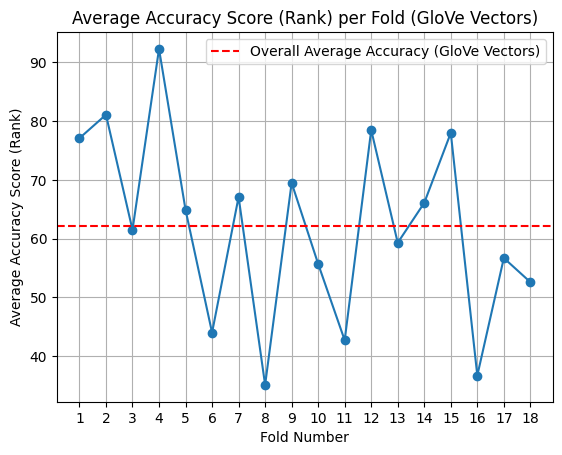

In [19]:
import matplotlib.pyplot as plt

glove_overall_average_accuracy = np.mean(glove_fold_accuracies)
print(f"Overall average accuracy score: {glove_overall_average_accuracy:.2f}")

plt.plot(range(1, n_folds + 1), glove_fold_accuracies, marker='o')
plt.axhline(y=glove_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (GloVe Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (GloVe Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

### Which concepts can be decoded with more or less success?

In [22]:
glove_concept_accuracies = dict(sorted(glove_concept_accuracies.items(), key=lambda item: item[1]))

In [23]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(glove_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: do, Concept Rank: 1.00
Concept: time, Concept Rank: 2.00
Concept: food, Concept Rank: 3.00
Concept: great, Concept Rank: 5.00
Concept: lady, Concept Rank: 5.00
Concept: laugh, Concept Rank: 5.00
Concept: music, Concept Rank: 5.00
Concept: picture, Concept Rank: 5.00
Concept: feeling, Concept Rank: 6.00
Concept: money, Concept Rank: 6.00


In [24]:
print("\nThe last 10 concepts are:")
for concept, concept_accuracy in list(glove_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")


The last 10 concepts are:
Concept: sew, Concept Rank: 155.00
Concept: movie, Concept Rank: 156.00
Concept: dissolve, Concept Rank: 160.00
Concept: kindness, Concept Rank: 160.00
Concept: usable, Concept Rank: 163.00
Concept: electron, Concept Rank: 167.00
Concept: deceive, Concept Rank: 173.00
Concept: applause, Concept Rank: 174.00
Concept: cockroach, Concept Rank: 178.00
Concept: argumentatively, Concept Rank: 180.00


### Using semantic vectors to decode brain activation (using custom GloVe)

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
custom_glove_concept_accuracies, custom_glove_fold_accuracies = test_accuracy(folds, custom_glove_vectors)

Overall average accuracy score (Word2Vec): 59.92


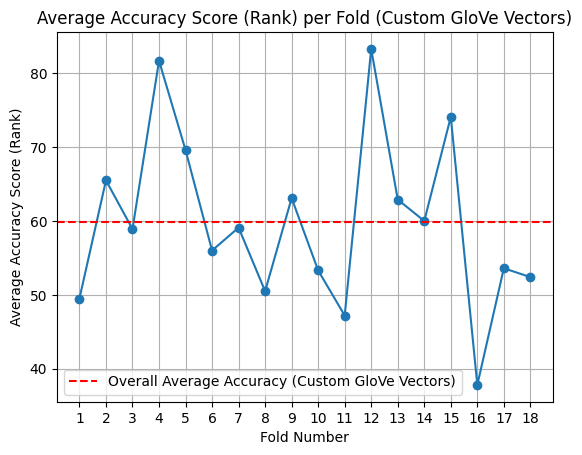

In [27]:
custom_glove_overall_average_accuracy = np.mean(custom_glove_fold_accuracies)
print(f"Overall average accuracy score (Word2Vec): {custom_glove_overall_average_accuracy:.2f}")
plt.plot(range(1, n_folds + 1), custom_glove_fold_accuracies, marker='o')
plt.axhline(y=custom_glove_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (Custom GloVe Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (Custom GloVe Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

### Which concepts can be decoded with more or less success?

In [28]:
custom_glove_concept_accuracies = dict(sorted(custom_glove_concept_accuracies.items(), key=lambda item: item[1]))

In [29]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(custom_glove_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: argumentatively, Concept Rank: 1.00
Concept: hair, Concept Rank: 3.00
Concept: do, Concept Rank: 3.00
Concept: time, Concept Rank: 4.00
Concept: laugh, Concept Rank: 5.00
Concept: big, Concept Rank: 5.00
Concept: feeling, Concept Rank: 6.00
Concept: soul, Concept Rank: 6.00
Concept: skin, Concept Rank: 7.00
Concept: emotion, Concept Rank: 7.00


In [30]:
print("\nThe last 10 concepts are:")
for concept, concept_accuracy in list(custom_glove_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")


The last 10 concepts are:
Concept: sew, Concept Rank: 145.00
Concept: sin, Concept Rank: 148.00
Concept: willingly, Concept Rank: 150.00
Concept: dissolve, Concept Rank: 151.00
Concept: beat, Concept Rank: 153.00
Concept: electron, Concept Rank: 155.00
Concept: elegance, Concept Rank: 157.00
Concept: deceive, Concept Rank: 158.00
Concept: usable, Concept Rank: 171.00
Concept: cockroach, Concept Rank: 176.00


### Using semantic vectors to decode brain activation (using Word2Vec)

In [31]:
# Now let's do the same for the word2vec vectors
word2vec_concept_accuracies, word2vec_fold_accuracies = test_accuracy(folds, word2vec_vectors)

Overall average accuracy score (Word2Vec): 56.58


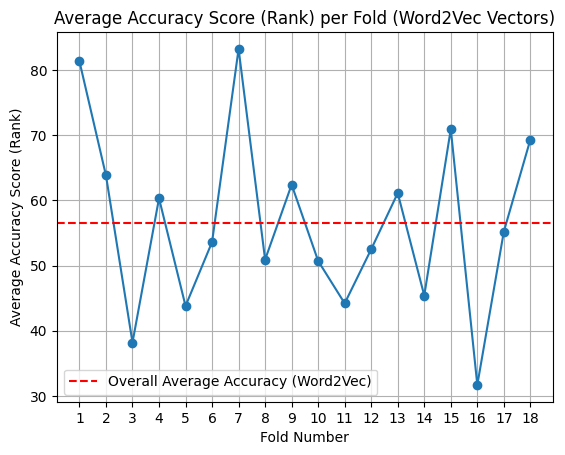

In [32]:
word2vec_overall_average_accuracy = np.mean(word2vec_fold_accuracies)
print(f"Overall average accuracy score (Word2Vec): {word2vec_overall_average_accuracy:.2f}")
plt.plot(range(1, n_folds + 1), word2vec_fold_accuracies, marker='o')
plt.axhline(y=word2vec_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (Word2Vec)')
plt.title('Average Accuracy Score (Rank) per Fold (Word2Vec Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

### Which concepts can be decoded with more or less success?

In [33]:
word2vec_concept_accuracies = dict(sorted(word2vec_concept_accuracies.items(), key=lambda item: item[1]))

In [34]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(word2vec_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: feeling, Concept Rank: 1.00
Concept: food, Concept Rank: 2.00
Concept: business, Concept Rank: 2.00
Concept: music, Concept Rank: 2.00
Concept: stupid, Concept Rank: 2.00
Concept: art, Concept Rank: 2.00
Concept: lady, Concept Rank: 2.00
Concept: play, Concept Rank: 3.00
Concept: smart, Concept Rank: 4.00
Concept: emotion, Concept Rank: 4.00


In [35]:
print("The last 10 concepts are:")
for concept, concept_accuracy in list(word2vec_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The last 10 concepts are:
Concept: spoke, Concept Rank: 143.00
Concept: movie, Concept Rank: 144.00
Concept: sin, Concept Rank: 147.00
Concept: jungle, Concept Rank: 149.00
Concept: deceive, Concept Rank: 165.00
Concept: electron, Concept Rank: 167.00
Concept: vacation, Concept Rank: 168.00
Concept: camera, Concept Rank: 169.00
Concept: sew, Concept Rank: 170.00
Concept: applause, Concept Rank: 174.00
